In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
print(os.listdir("../input"))

# Any results you write to the current directory are saved as output.

In [ ]:
test = pd.read_csv('../input/test.csv')
item_categories = pd.read_csv('../input/item_categories.csv')
items = pd.read_csv('../input/items.csv')
shops = pd.read_csv('../input/shops.csv')
train = pd.read_csv('../input/sales_train.csv', parse_dates=['date'])

In [29]:
train.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,2013-02-01,0,59,22154,999.00,1.0
1,2013-03-01,0,25,2552,899.00,1.0
2,2013-05-01,0,25,2552,899.00,-1.0
3,2013-06-01,0,25,2554,1709.05,1.0
4,2013-01-15,0,25,2555,1099.00,1.0


In [66]:
items.head()

,item_name,item_id,item_category_id
0,! ВО ВЛАСТИ НАВАЖДЕНИЯ (ПЛАСТ.) D,0,40
1,!ABBYY FineReader 12 Professional Edition Full...,1,76
2,***В ЛУЧАХ СЛАВЫ (UNV) D,2,40
3,***ГОЛУБАЯ ВОЛНА (Univ) D,3,40
4,***КОРОБКА (СТЕКЛО) D,4,40


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns 
import altair as alt 

/opt/conda/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


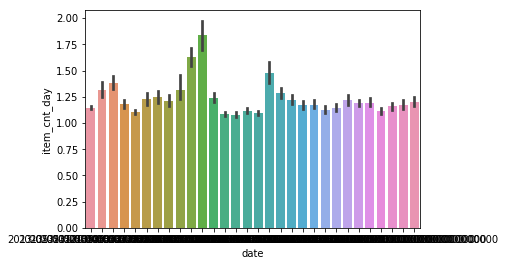

In [28]:
a=train[(train['date']> '2013-04-30') & (train['date'] < '2013-05-31') ]

sns.barplot(x=a['date'],y=a['item_cnt_day'])


In [75]:
a=train[train['date']<'2014-01-01'].groupby(['item_id'])['item_cnt_day'].sum()
z=pd.DataFrame(a)

z.sort_values(by='item_cnt_day',ascending=False).head(10)


,item_cnt_day
item_id,
20949,63748.0
2808,12214.0
3732,11981.0
3734,7649.0
16787,6430.0
6738,5924.0
1830,5640.0
2445,5330.0
3331,5114.0


In [77]:
a=train[(train['date']>'2014-01-01')&(train['date']<'2015-01-01')].groupby('item_id')['item_cnt_day'].sum()
z=pd.DataFrame(a)

z.sort_values(by='item_cnt_day',ascending=False).head(10)

,item_cnt_day
item_id,
20949,85149.0
17717,7391.0
2814,7096.0
5822,6538.0
6675,5524.0
3733,5322.0
16790,5292.0
1855,5158.0
3928,5116.0


In [79]:
a=train[(train['date']>'2015-01-01')&(train['date']<'2016-01-01')].groupby('item_id')['item_cnt_day'].sum()
z=pd.DataFrame(a)

z.sort_values(by='item_cnt_day',ascending=False).head(10)

,item_cnt_day
item_id,
20949,38438.0
3731,10099.0
17717,7244.0
10210,4876.0
11373,4408.0
10209,4213.0
5822,4109.0
9355,3115.0
6503,3023.0


In [94]:
pd.set_option('display.max_colwidth', -1)
# items[items['item_id']==4894]

item_categories.head(20)

,item_category_name,item_category_id
0,PC - Гарнитуры/Наушники,0
1,Аксессуары - PS2,1
2,Аксессуары - PS3,2
3,Аксессуары - PS4,3
4,Аксессуары - PSP,4
5,Аксессуары - PSVita,5
6,Аксессуары - XBOX 360,6
7,Аксессуары - XBOX ONE,7
8,Билеты (Цифра),8
9,Доставка товара,9


In [35]:
train[(train['date']>'2014-01-01')&(train['date']<'2015-01-01')].groupby('date_block_num')['item_cnt_day'].sum()

date_block_num
12    114589.0
13    109687.0
14    115297.0
15     96556.0
16     97790.0
17     97429.0
18     91280.0
19    102721.0
20     99208.0
21    107422.0
22    117845.0
23    168755.0
Name: item_cnt_day, dtype: float64

In [106]:
a=train[(train['date']> '2013-11-30') & (train['date'] < '2013-12-05') ].groupby('item_id')['item_cnt_day'].sum()
z=pd.DataFrame(a)
sns.barplot(x='item_id',y='item_cnt_day',data=z)

ValueError: Could not interpret input 'item_id'

In [96]:
train[(train['date']> '2013-11-30') & (train['date'] < '2013-12-05') ].sort_values('item_cnt_day',ascending=False)

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
239024,2013-12-03,2,31,6738,699.000000,88.0
319112,2013-12-03,2,25,6738,699.000000,69.0
295437,2013-12-03,2,6,6738,696.543860,57.0
269148,2013-12-03,2,42,6738,698.994643,56.0
270357,2013-12-03,2,43,6738,695.585366,41.0
241535,2013-12-03,2,31,1830,299.500000,40.0
279618,2013-12-03,2,18,6738,699.000000,38.0
325677,2013-12-03,2,26,6738,691.432432,37.0
276085,2013-12-03,2,50,6738,699.000000,36.0
232596,2013-12-03,2,46,6738,699.000000,35.0
